In [54]:
import pandas as pd
import polars as pl
import torch
from utils.plot_utils import set_theme, predict
from data import KFoldEncodeModule
from torchmetrics import R2Score, MeanSquaredError
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

set_theme()
pd.set_eng_float_format(accuracy=2)

In [55]:
from lightning_model import Netlightning

model = Netlightning.load_from_checkpoint(
    "../runs/regression_bloom/bloom2015_reg/bloom2015_reg-2epoch=36-step=58460.ckpt",
    loss_function="mse",
)
model.eval()

Netlightning(
  (net): Net(
    (activation): CELU(alpha=1.0)
    (sequence): Sequential(
      (0): Linear(in_features=6078, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): CELU(alpha=1.0)
      (3): Linear(in_features=1024, out_features=512, bias=True)
      (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): CELU(alpha=1.0)
      (6): Linear(in_features=512, out_features=256, bias=True)
      (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): CELU(alpha=1.0)
      (9): Linear(in_features=256, out_features=128, bias=True)
      (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): CELU(alpha=1.0)
      (12): Linear(in_features=128, out_features=64, bias=True)
      (13): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (14): CELU

In [56]:
train = "Bloom2015"
test = "Bloom2013"
filename="../data/regression_data/bloom2013_regression.feather"

In [57]:
data = pd.read_feather(filename)
data.drop(columns=["Strain"], inplace=True)
variation_columns = [col for col in data.columns if col.startswith("Y")]
data.head()

,YAL001C,YAL002W,YAL003W,YAL004W,YAL005C,YAL007C,YAL008W,YAL009W,YAL010C,YAL011W,...,latent_56,latent_57,latent_58,latent_59,latent_60,latent_61,latent_62,latent_63,Phenotype,Condition
0,0,0,0,0,0,0,0,0,0,0,...,-1.70E+00,-2.38E+00,3.69E+00,3.70E+00,-1.47E+00,2.43E+00,682.12E-03,-1.83E+00,-7.32E+00,CdCl2
1,0,1,1,0,1,0,0,0,1,1,...,-1.70E+00,-2.38E+00,3.69E+00,3.70E+00,-1.47E+00,2.43E+00,682.12E-03,-1.83E+00,-8.10E+00,CdCl2
2,0,1,1,0,1,0,0,0,1,1,...,-1.70E+00,-2.38E+00,3.69E+00,3.70E+00,-1.47E+00,2.43E+00,682.12E-03,-1.83E+00,7.61E+00,CdCl2
3,0,0,0,0,0,0,0,0,0,0,...,-1.70E+00,-2.38E+00,3.69E+00,3.70E+00,-1.47E+00,2.43E+00,682.12E-03,-1.83E+00,-6.15E+00,CdCl2
4,0,1,1,0,1,0,0,0,0,0,...,-1.70E+00,-2.38E+00,3.69E+00,3.70E+00,-1.47E+00,2.43E+00,682.12E-03,-1.83E+00,9.38E+00,CdCl2


In [58]:
from sklearn.model_selection import train_test_split

_, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [59]:
results_df = pd.DataFrame(columns=["Compound", "MSE", "R-squared"])

# fig, axes = plt.subplots(5, 8, figsize=(16,12), sharex=True, sharey=True, tight_layout=True)

pred_dict = dict()
mse = MeanSquaredError()
r2 = R2Score()

for i, key in enumerate(test_data.Condition.unique()):
    
    condition_test = test_data[test_data["Condition"] == key]
    X = torch.tensor(condition_test.drop(["Condition","Phenotype"], axis=1).values).float()
    y = torch.tensor(condition_test["Phenotype"].values).float().unsqueeze(1)
    
    y_pred = predict(model, X).to("cpu")

    mse_val = mse(y_pred, y).detach().item()
    r2_val = r2(y_pred, y).detach().item()
    
    print(f"{key}", end=": ")
    print(f"MSE:  {mse_val:.2f}", " | ", f"R2: , {r2_val:.2f}")
    
    pred_dict[key] = y_pred.reshape(-1).detach().numpy()
    
    results_df.loc[i] = [key, mse_val, r2_val]
    

zeocin: MSE:  35.03  |  R2: , 0.11
mannose: MSE:  1.22  |  R2: , 0.03
lactate: MSE:  0.99  |  R2: , 0.29
CoCl2: MSE:  7.47  |  R2: , 0.19
H2O2: MSE:  9.38  |  R2: , -0.01
menadione: MSE:  0.74  |  R2: , 0.23
fluorouracil: MSE:  3.44  |  R2: , 0.01
6-azauracil: MSE:  0.79  |  R2: , -0.18
caffeine: MSE:  0.92  |  R2: , -0.19
MgSO4: MSE:  3.19  |  R2: , -0.05
galactose: MSE:  1.60  |  R2: , -0.02
copper: MSE:  3.44  |  R2: , -0.03
diamide: MSE:  16.82  |  R2: , 0.10
sds: MSE:  1.71  |  R2: , -0.02
hydroquinone: MSE:  4.39  |  R2: , -0.00
ethanol: MSE:  3.55  |  R2: , 0.07
cycloheximide: MSE:  3.25  |  R2: , -0.05
MgCl2: MSE:  0.80  |  R2: , 0.10
raffinose: MSE:  0.85  |  R2: , 0.10
paraquat: MSE:  3.96  |  R2: , -0.07
neomycin: MSE:  37.12  |  R2: , 0.08
cisplatin: MSE:  1.29  |  R2: , -0.19
congo_red: MSE:  39.30  |  R2: , -0.02
CdCl2: MSE:  35.04  |  R2: , -0.02
CaCl2: MSE:  0.47  |  R2: , 0.08
indoleacetic_acid: MSE:  1.65  |  R2: , 0.13
hydroxybenzaldehyde: MSE:  6.22  |  R2: , -0.05


In [60]:
results_df["Compound"] = results_df["Compound"].astype(str)
print(results_df[["MSE", "R-squared"]].apply(lambda x: str(x.mean()) + " ± " + str(x.std()), axis=0))

MSE             8.887768646845451 ± 12.732151313444483
R-squared    0.04139760671517788 ± 0.11787759250122465
dtype: object


Text(0.5, 0.98, 'Bloom2015 Model on Bloom2013 - Regression')

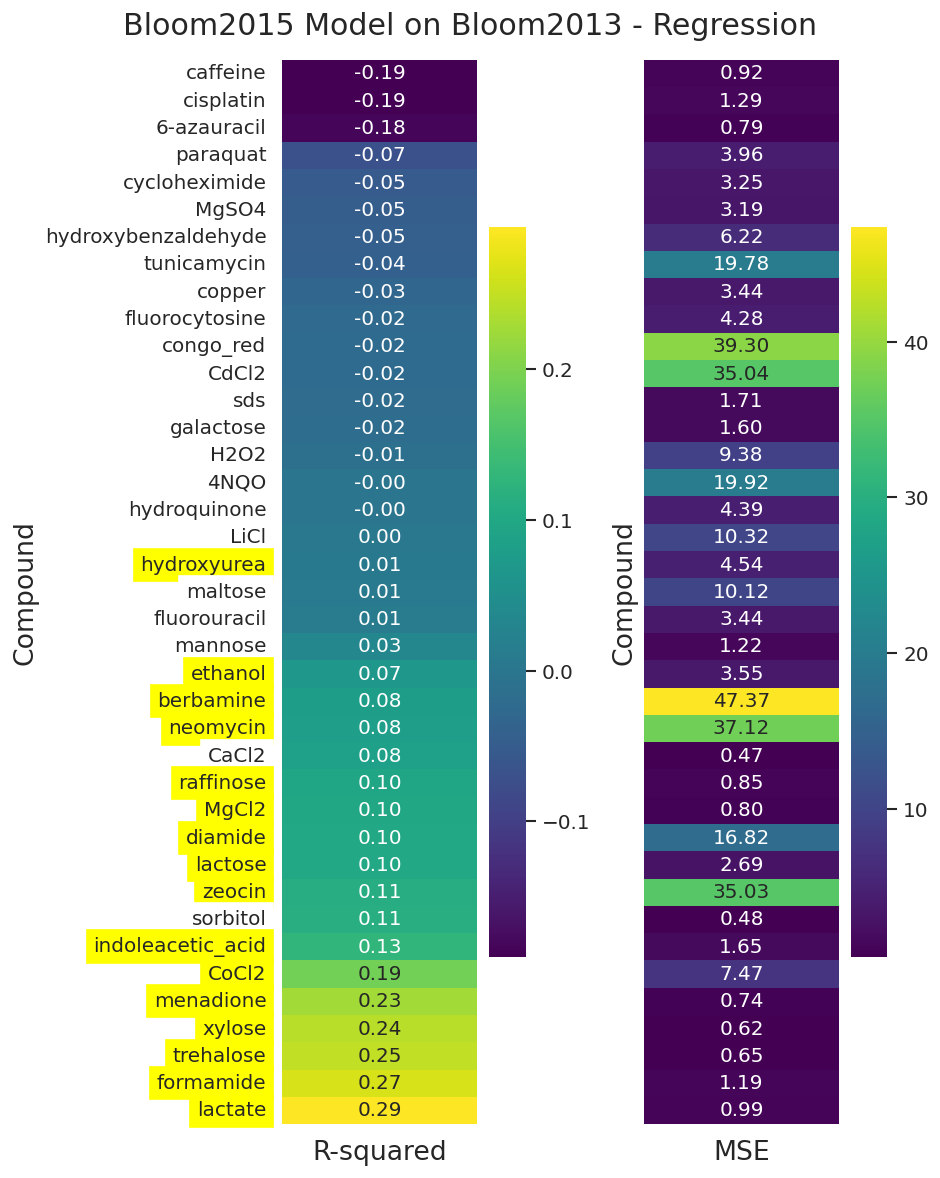

In [61]:
fig2, ax = plt.subplots(1,2,figsize=(8,10), sharey=True, tight_layout=True)

sns.heatmap(results_df.set_index('Compound').drop(['MSE'], axis=1).sort_values('R-squared'), cmap='viridis', annot=True, fmt='.2f', ax=ax[0])
sns.heatmap(results_df.set_index('Compound').sort_values('R-squared').drop(['R-squared'], axis=1), cmap='viridis', annot=True, fmt='.2f', ax=ax[1])

bloom_2013_chemicals = np.array(['berbamine', 'cocl2', 'diamide', 'ethanol', 'formamide',
       'hydroxyurea', 'lactate', 'lactose', 'menadione', 'mgcl2', 'indoleacetic_acid',
       'neomycin', 'raffinose', 'trehalose', 'xylose', 'zeocin'],
      dtype='<U19')

for text in ax[0].get_yticklabels():
    if text.get_text().lower() in bloom_2013_chemicals: 
        text.set(backgroundcolor = "yellow")
    else:
        text.set(backgroundcolor = "white")
plt.suptitle(f"{train} Model on {test} - Regression", size=18)

Text(0.5, 0, 'True')

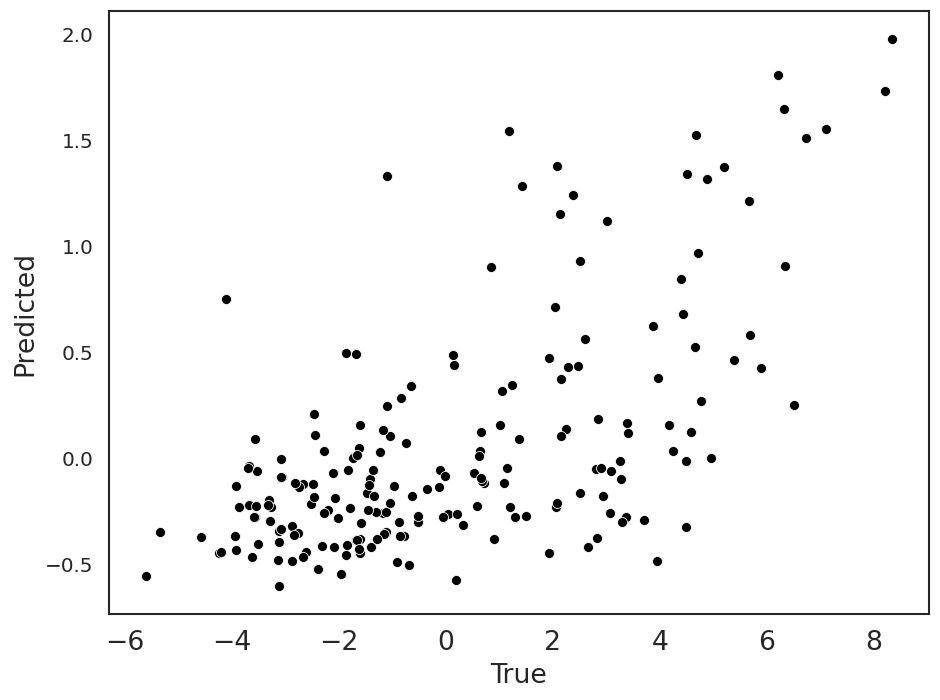

In [62]:
fig, ax = plt.subplots(figsize=(8,6), tight_layout=True)

condition = "CoCl2"
sns.scatterplot(x=test_data[test_data["Condition"] == condition]["Phenotype"], y=pred_dict[condition])
ax.set_ylabel("Predicted")
ax.set_xlabel("True")


Text(0.5, 1.0, 'Histogram of phenotype values')

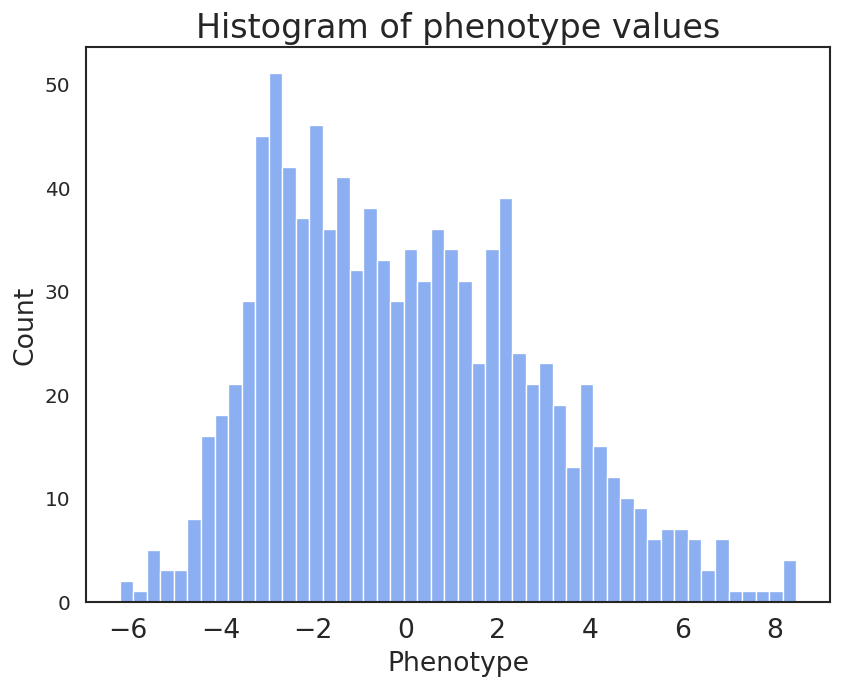

In [63]:
sns.histplot(x = data[data["Condition"] == condition]["Phenotype"], bins=50, color="cornflowerblue")
plt.title("Histogram of phenotype values")

Text(0.5, 1.0, 'Histogram of phenotype values - Test Set')

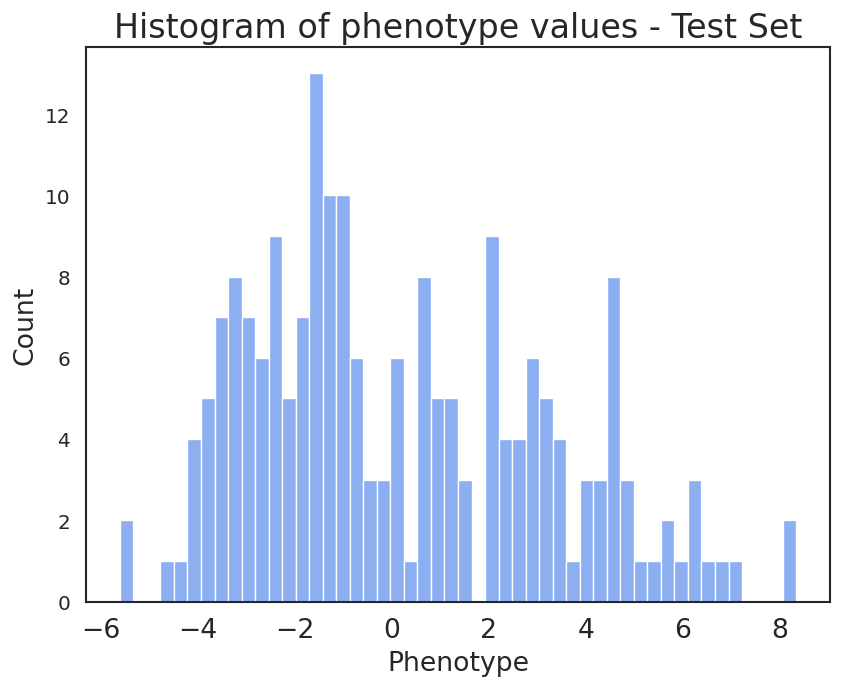

In [64]:
sns.histplot(x = test_data[test_data["Condition"] == condition]["Phenotype"], bins=50, color="cornflowerblue")
plt.title("Histogram of phenotype values - Test Set")